## Preparation

Used Datasets:
- [Fashion Product Images (Small)](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small)
- [Fashion MNIST PNG](https://www.kaggle.com/datasets/andhikawb/fashion-mnist-png) (there's [similar one](https://www.kaggle.com/datasets/prashantdandriyal/mnistfashionpng) but has wrong labels)

Similar Datasets:
- [H&M Personalized Fashion Recommendations](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations)
- Clothes Segmentation (Kaggle search keyword)

In [1]:
from tensorflow import keras
import plotly.io as pio
import tensorflow as tf

# Disable interactive visualization
# Requires kaleido and nbformat
pio.renderers.default = 'svg'
pio.templates.default = 'plotly_dark'

# Disable annoying TensorFlow messages
tf.get_logger().setLevel('ERROR')

# Set seed for possible reproducibility
# Affect Python, Numpy, and Keras
keras.utils.set_random_seed(1337)

# Check available GPU for TensorFlow
print(tf.config.list_physical_devices('GPU'))


[]


### Extract Zip Files

In [2]:
import os
import glob
import shutil
import zipfile

# Follow Kaggle directory structures
# Input should be read only after zip extraction
input_dir = 'input'
misc_dir = 'misc'

# Dataset folders
data1_dir = f'{input_dir}/fashion-product-images-small'
data2_dir = f'{input_dir}/fashion-mnist-png'

def extract_multi_zips(base_zip_name: str, in_dir: str, out_dir: str, check_out_dir = False):
    # Combine multiple zips onto a single zip
    with open(f'{in_dir}/{base_zip_name}.zip', 'wb') as zip_final:
        for zip_part in glob.glob(f'{in_dir}/{base_zip_name}.zip.*'):
            with open(zip_part, 'rb') as f:
                shutil.copyfileobj(f, zip_final)

    # Don't extract if output directory already exist
    if check_out_dir and os.path.exists(out_dir): return
    # Extract the previously combined zip to output directory
    with zipfile.ZipFile(f'{in_dir}/{base_zip_name}.zip') as zip:
        zip.extractall(out_dir)

# --------------------

os.makedirs(misc_dir, exist_ok = True)

# extract_multi_zips('data1', input_dir, data1_dir, True)
# extract_multi_zips('data2', input_dir, data2_dir, True)

# Latest saved model
extract_multi_zips('model_v8', 'archive', misc_dir, False)

### Read Data from the First Dataset

In [3]:
import pandas as pd

def join_last_cols(cols):
    # More columns detected due to comma in string
    if len(cols) > len(headers):
        for i in range(len(headers), len(cols)):
            # Get index of last valid column
            last_col = len(headers) - 1
            # Combine every string after last column
            cols[last_col] = cols[last_col] + ',' + cols[i]
    # Slice invalid columns after combining string
    return cols[:len(headers)]

# Get header list first to mitigate bad columns when reading CSV
headers = list(pd.read_csv(f'{data1_dir}/styles.csv', nrows = 0).columns)
df1 = pd.read_csv(f'{data1_dir}/styles.csv', on_bad_lines = join_last_cols, engine = 'python')
del headers

df1.head(1)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt


In [4]:
# Add image path as column
df1['image'] = f'{data1_dir}/images/' + df1['id'].astype(str) + '.jpg'
df1.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,input/fashion-product-images-small/images/1597...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,input/fashion-product-images-small/images/3938...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,input/fashion-product-images-small/images/5926...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,input/fashion-product-images-small/images/2137...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,input/fashion-product-images-small/images/5375...


There are many columns, but to develop a prediction model, perhaps the most important ones are `articleType` and `baseColour`.

However, extracting color with CNN is harder than extracting shape, and there are not many augmentation methods for color, so I'm going to use `articleType`.

In [5]:
# Mark image and label column
x_col = 'image'
y_col = 'articleType'

In [6]:
# See the CSV file for more details
df1[y_col].value_counts()

articleType
Tshirts                7070
Shirts                 3217
Casual Shoes           2846
Watches                2542
Sports Shoes           2036
                       ... 
Shoe Laces                1
Mens Grooming Kit         1
Body Wash and Scrub       1
Suits                     1
Ipad                      1
Name: count, Length: 143, dtype: int64

### Read Data from the Second Dataset
Additional dataset (fashion MNIST) is needed since the model accuracy is still too low if only using the first dataset. Train and test data can be combined since we will be using `ImageDataGenerator` to split the data later.

**NOTE:** Fashion MNIST only has greyscale images.

In [7]:
list_labels = []
list_images = []

# Loop test and train folder
for traval in os.listdir(data2_dir):
    if os.path.isfile(f'{data2_dir}/{traval}'): continue

    for label in os.listdir(f'{data2_dir}/{traval}'):
        # Subdir should be class/label name (as folder)
        subdir = f'{data2_dir}/{traval}/{label}'
        if os.path.isfile(f'{data2_dir}/{traval}'): continue

        for file in os.listdir(subdir):
            # File path should be an image
            file_path = f'{subdir}/{file}'

            if os.path.isfile(file_path):
                list_images.append(file_path)
                list_labels.append(label)

df2 = pd.DataFrame({
    y_col: list_labels,
    x_col: list_images
})

del list_labels
del list_images

df2.head()

,articleType,image
0,0,input/fashion-mnist-png/test/0/1000.png
1,0,input/fashion-mnist-png/test/0/1005.png
2,0,input/fashion-mnist-png/test/0/1038.png
3,0,input/fashion-mnist-png/test/0/1049.png
4,0,input/fashion-mnist-png/test/0/1052.png


Convert numeric classes to their real names (for easier analysis).

In [8]:
df2['articleType'] = df2['articleType'].replace({
    '0': 'Tshirts', # T-shirt/top
    '1': 'Trousers', # Trouser
    '2': 'Pullovers', # Pullover
    '3': 'Dresses', # Dress
    '4': 'Coats', # Coat
    '5': 'Sandals', # Sandal
    '6': 'Shirts', # Shirt
    '7': 'Sneakers', # Sneaker
    '8': 'Bags', # Bag
    '9': 'Ankle Boots' # Ankle boot
})

df2.head()

,articleType,image
0,Tshirts,input/fashion-mnist-png/test/0/1000.png
1,Tshirts,input/fashion-mnist-png/test/0/1005.png
2,Tshirts,input/fashion-mnist-png/test/0/1038.png
3,Tshirts,input/fashion-mnist-png/test/0/1049.png
4,Tshirts,input/fashion-mnist-png/test/0/1052.png


### Combine All Datasets

In [9]:
df = pd.concat([df1, df2], ignore_index = True)
print('Total rows:', len(df))
df.tail()

Total rows: 114446


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
114441,NaN,NaN,NaN,NaN,Ankle Boots,NaN,NaN,NaN,NaN,NaN,input/fashion-mnist-png/train/9/9965.png
114442,NaN,NaN,NaN,NaN,Ankle Boots,NaN,NaN,NaN,NaN,NaN,input/fashion-mnist-png/train/9/998.png
114443,NaN,NaN,NaN,NaN,Ankle Boots,NaN,NaN,NaN,NaN,NaN,input/fashion-mnist-png/train/9/9980.png
114444,NaN,NaN,NaN,NaN,Ankle Boots,NaN,NaN,NaN,NaN,NaN,input/fashion-mnist-png/train/9/9991.png
114445,NaN,NaN,NaN,NaN,Ankle Boots,NaN,NaN,NaN,NaN,NaN,input/fashion-mnist-png/train/9/9992.png


## Simple EDA

### See Class Distribution

Total classes: 148


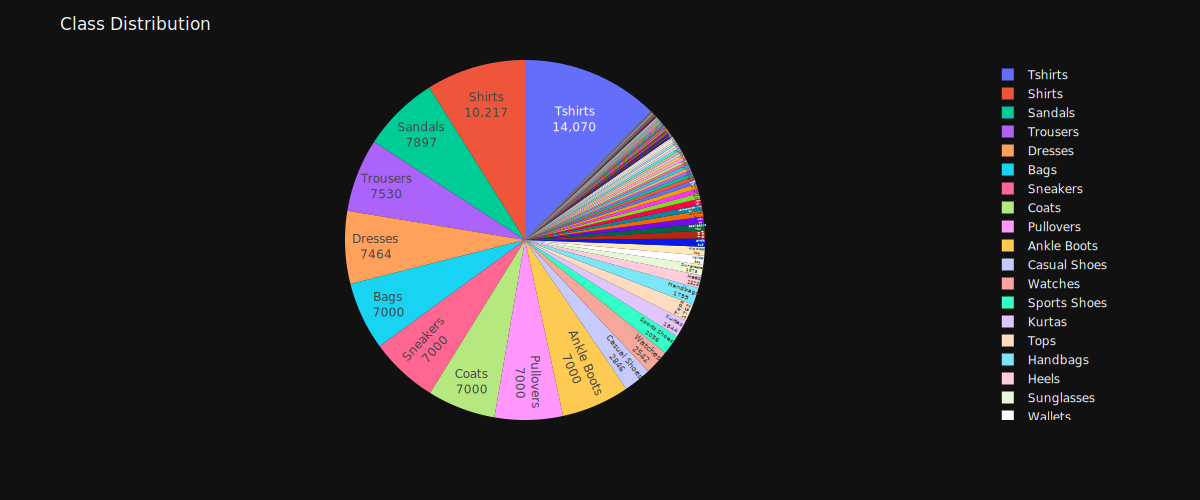

In [10]:
import plotly.express as px

temp = df[y_col].value_counts()
print('Total classes:', len(temp))

fig = px.pie(temp, names = temp.index, values = temp.values)
fig.update_traces(textposition = 'inside', textinfo = 'label+value') # label+percent
fig.update_layout(title = 'Class Distribution')
fig.show(width = 1200)

### See the Top N Classes
Since there are too many classes, we can separate classes by dataset first to analyze them.

In [11]:
from IPython.display import display_html
import pandas as pd

def display_inline(dfs: list, titles: list = None, row_limit = 5, scrollable = False):
    '''Display Pandas' dataframes (wrapped in a list) as grid, support nested dataframes (2D list)'''
    # Dataframes can be wrapped in 2D nested list, but the title should not be nested
    # Only one title will be used for nested dataframes
    if titles == None: titles = [ f'' for i in dfs ]

    output = '<span>'
    for (title, df) in zip(titles, dfs):
        length = len(df)

        output += '<div style="display: inline-block; border: 0.5px solid">'
        output += f'<div style="text-align: center">{title} (len: {length})</div>'

        if isinstance(df, list):
            for nested_df in df:
                nested_df = nested_df.head(row_limit)
                if scrollable: output += display_scrollable(nested_df, raw_only = True)
                else: output += nested_df.to_html(notebook = True)
        else:
            df = df.head(row_limit)
            if scrollable: output += display_scrollable(df, raw_only = True)
            else: output += df.to_html(notebook = True)

        output += '</div>'
    output += '</span>'

    display_html(output, raw = True)

def display_scrollable(df: pd.DataFrame, row_limit = 500, height = 200, raw_only = False):
    '''Display scrollable dataframe, or return the HTML text only (`raw_only = True`)'''
    if len(df) > row_limit: df = df.head(row_limit)

    html = (
        f'<div style="height: {height}px; overflow: auto; width: fit-content">' +
        df.to_html(notebook = True) + '</div>'
    )

    if raw_only: return html
    else: display_html(html, raw = True)

def series_to_df(series: pd.Series, rename_index: str = None):
    '''Convert series to dataframe and rename the index if needed'''
    df = series.to_frame()
    if rename_index:
        df = df.rename_axis(rename_index).reset_index()
    return df

In [12]:
num_classes = 999

df1_classes = df1[y_col].value_counts()[:num_classes]
df2_classes = df2[y_col].value_counts()[:num_classes]
df_classes = df[y_col].value_counts()[:num_classes]

display_inline(
    [
        series_to_df(df1_classes, 'class'),
        series_to_df(df2_classes, 'class'),
        series_to_df(df_classes, 'class'),
    ],
    titles = ['df1', 'df2', 'combined'],
    row_limit = num_classes,
    scrollable = True
)

,class,count
0,Tshirts,7070
1,Shirts,3217
2,Casual Shoes,2846
3,Watches,2542
4,Sports Shoes,2036
5,Kurtas,1844
6,Tops,1762
7,Handbags,1759
8,Heels,1323
9,Sunglasses,1073


**NOTE:** Individual dataset won't be used for model training, so make sure to modify only the combined dataset (if needed).

In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from PIL import Image
import numpy as np

def show_image_samples(df: pd.DataFrame, label: str, n_rows = 1, n_cols = 8):
    df = df[df[y_col] == label].sample(n_rows * n_cols)

    fig = make_subplots(
        rows = n_rows, cols = n_cols
    )

    for i in range(n_rows):
        for j in range(n_cols):
            image = df[x_col].values[i * n_cols + j]
            if os.path.isfile(image):
                image = Image.open(image)
                image = image.resize(size = (80, 80))

                if np.asarray(image).shape[-1] == 3:
                    image = go.Image(z = image)
                else:
                    image = go.Heatmap(z = image)

                fig.add_trace(image, row = i + 1, col = j + 1)

    fig.update_layout(title = f'Sample Images for {label}')
    fig.update_xaxes(showticklabels = False).update_yaxes(showticklabels = False, autorange = 'reversed')
    fig.show(height = 300, width = 1200)

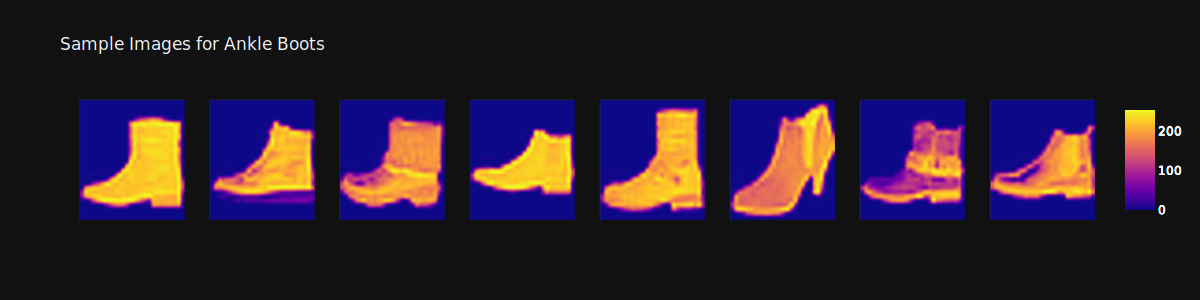

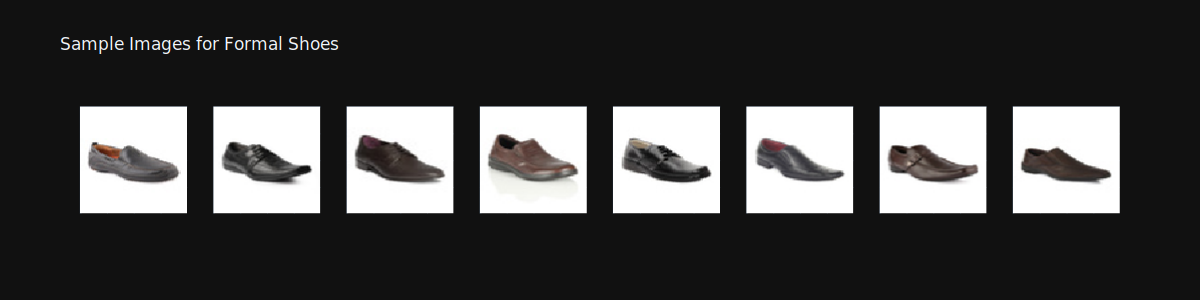

In [14]:
# View samples of certain label(s)
temp = ['Ankle Boots', 'Formal Shoes']

for label in temp:
    show_image_samples(df, label)

Observation:
- Tshirts and tops can be combined
- Sandals, flip flops, and sports sandals can be combined
- Trousers and jeans look a bit similar in shape, though the colors are quite distinct
- Dresses and nightdress can be combined
- Jackets and coats can be combined
- Bags, backpacks, handbags, laptop bag, and messenger bag can be combined
- Sneakers and casual shoes can be combined
- Sweaters contain vests and are mostly knitted, but there are some that looks like normal shirt
- Sweaters, pullovers, and sweatshirts look similar so they can be combined. Some of these also have a hoodie so there will be a small overlap with jackets
- Formal shoes and ankle boots are not mutual, though there are a few that are similar. They can both be dropped/ignored

## Data Preprocessing

### Generalize Some Classes
Some classes need to be renamed/combined together since there are not much difference. This may also increase the model accuracy by reducing false positives.

In order to combine multiple classes, we may need to observe the sample images of each class and dataset manually (see above).

In [15]:
df[y_col] = df[y_col].replace('Tops', 'Tshirts')
df[y_col] = df[y_col].replace('Flip Flops', 'Sandals')
df[y_col] = df[y_col].replace('Sports Sandals', 'Sandals')
df[y_col] = df[y_col].replace('Nightdress', 'Dresses')
df[y_col] = df[y_col].replace('Coats', 'Jackets')
df[y_col] = df[y_col].replace('Backpacks', 'Bags')
df[y_col] = df[y_col].replace('Handbags', 'Bags')
df[y_col] = df[y_col].replace('Laptop Bag', 'Bags')
df[y_col] = df[y_col].replace('Messenger Bag', 'Bags')
df[y_col] = df[y_col].replace('Sneakers', 'Casual Shoes')
df[y_col] = df[y_col].replace('Pullovers', 'Sweaters')
df[y_col] = df[y_col].replace('Sweatshirts', 'Sweaters')

### Drop Other Classes
To reduce error rate caused by insufficient samples or false positives, we should take only a few classes (that contain samples from all datasets).

In [16]:
display_scrollable(
    series_to_df(df[y_col].value_counts(), 'class')
)

,class,count
0,Tshirts,15832
1,Shirts,10217
2,Casual Shoes,9846
3,Bags,9609
4,Sandals,8880
5,Dresses,7653
6,Sweaters,7562
7,Trousers,7530
8,Jackets,7258
9,Ankle Boots,7000


The last class that has samples from all datasets is jackets (at index 8)

In [17]:
# Notice the +1
num_classes = 9

temp = df[y_col].value_counts()[:num_classes].index
df = df[df[y_col].isin(temp)]

print(temp)
print(df[y_col].unique())

if len(temp) != len(df[y_col].unique()):
    raise ValueError('Both labels don\'t match!')

Index(['Tshirts', 'Shirts', 'Casual Shoes', 'Bags', 'Sandals', 'Dresses',
       'Sweaters', 'Trousers', 'Jackets'],
      dtype='object', name='articleType')
['Shirts' 'Tshirts' 'Casual Shoes' 'Sandals' 'Bags' 'Sweaters' 'Dresses'
 'Trousers' 'Jackets']


### Drop Non-Existent Images

In [18]:
print('Before:', len(df))
df.drop(
    # Using apply may be slow, use list comprehension instead
    df[ [not os.path.isfile(i) for i in df[x_col]] ].index,
    inplace = True
)
print('After:', len(df))

# The RGB images will be used for recommender system too
# So make sure there is no row missmatch caused by non-existent image
print('Before:', len(df1))
df1.drop(
    df1[ [not os.path.isfile(i) for i in df1[x_col]] ].index,
    inplace = True
)
print('After:', len(df1))

Before: 84387
After: 84384
Before: 44446
After: 44441


## Image Augmentation

In [173]:
from PIL import Image
import numpy as np

def view_image_data(file_path):
    with Image.open(file_path) as image:
        print(f'Path: {file_path}')
        print(f'Image Format: {image.format}')
        print(f'Color Format: {image.mode}')
        print(f'Color Depth: {np.asarray(image).dtype}')
        print(f'Shape: {np.asarray(image).shape}\n')

temp = f'{data1_dir}/images/' + os.listdir(f'{data1_dir}/images')[0]
view_image_data(temp)

temp = f'{data2_dir}/test/0/' + os.listdir(f'{data2_dir}/test/0')[0]
view_image_data(temp)

Path: input/fashion-product-images-small/images/10000.jpg
Image Format: JPEG
Color Format: RGB
Color Depth: uint8
Shape: (80, 60, 3)

Path: input/fashion-mnist-png/test/0/1000.png
Image Format: PNG
Color Format: L
Color Depth: uint8
Shape: (28, 28)



Since the image shapes are not uniform/square, not all augmentations can be used (e.g. only limited rotation range). We can make it square first and resize it to a uniform size before applying more augmentations. Also, greyscale (L) images need to be converted to RGB.

**EDIT:** It seems that the image shape must be the same as specified for `flow_from_directory`, so changing the size after that will cause a missmatch error. Not used for now until I find a clean workaround.

In [174]:
from PIL import ImageOps, ImageFilter
from skimage import feature, color
import random

def square_and_resize(image: np.ndarray, pad_color = '#FFF', new_size = (80, 80)):
    if image.shape[0] < image.shape[1]: size = image.shape[1]
    else: size = image.shape[0]

    image = Image.fromarray(image.astype(np.uint8))
    # Resize to square and fill empty space with a color
    # https://pillow.readthedocs.io/en/stable/reference/ImageOps.html
    image = ImageOps.pad(image, (size, size), color = pad_color)
    # Resize image with bicubic interpolation
    image = image.resize(new_size, Image.BICUBIC)

    return np.asarray(image, dtype = keras.backend.floatx())

def grayscale_to_rgb(image: np.ndarray):
    image = Image.fromarray(image.astype(np.uint8))
    image = image.convert('RGB')
    
    return np.asarray(image, dtype = keras.backend.floatx())

# https://scikit-image.org/docs/stable/auto_examples/
def canny(image: np.ndarray, sigma: float = 1.5):
    if image.shape[-1] == 3:
        image = color.rgb2gray(image)
    elif image.shape[-1] == 1:
        image = image.squeeze(axis = -1)

    # Canny only accepts 2D array and return boolean array
    image = feature.canny(image, sigma = sigma)
    image = image.astype(np.uint8) * 255
    return image

# --------------------

def val_preproc(image: np.ndarray):
    image = grayscale_to_rgb(image)
    # image = square_and_resize(image)
    return image

def train_preproc(image: np.ndarray):
    rng = random.random()
    if rng <= 0.333: image = canny(image)
    image = val_preproc(image)
    return image

**NOTE:** Depending on the base model, rescaling may not be needed (already included as a layer, can be disabled using `include_preprocessing = False`). Most pre-trained models also scale to range -1 to 1 instead of 0 to 1.

In [175]:
# Scale pixel to range 0-1
rescale = False

In [176]:
from keras.preprocessing.image import ImageDataGenerator

if rescale: scale_factor = 1 / 255
else: scale_factor = 1

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://fairyonice.github.io/Learn-about-ImageDataGenerator.html
train_gen = ImageDataGenerator(
    rescale = scale_factor,
    shear_range = 0.2, # 3D rotation
    rotation_range = 20,
    fill_mode = 'nearest', # See fairyonice
    horizontal_flip = True,
    vertical_flip = False,
    validation_split = 0.2,
    # Inputs will be normal images (not augmented/rescaled yet)
    preprocessing_function = train_preproc
)

# train_gen and val_gen must have same seed later
# If not, train and val data may have overlapping samples
val_gen = ImageDataGenerator(
    rescale = scale_factor,
    validation_split = 0.2,
    preprocessing_function = val_preproc
)

In [177]:
# Images per batch
batch_size = 32
target_width = 80
target_height = 80
# binary (int), categorical (one hot), sparse (float 0-1)
# https://stackoverflow.com/q/63867609
class_mode = 'sparse'
seed = 1337

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe
train_data = train_gen.flow_from_dataframe(
    dataframe = df,
    x_col = x_col,
    y_col = y_col,
    # Non-existent images have been removed before
    validate_filenames = False,
    target_size = (target_height, target_width),
    batch_size = batch_size,
    class_mode = class_mode,
    subset = 'training',
    seed = seed
)

val_data = val_gen.flow_from_dataframe(
    dataframe = df,
    x_col = x_col,
    y_col = y_col,
    validate_filenames = False,
    target_size = (target_height, target_width),
    batch_size = batch_size,
    class_mode = class_mode,
    subset = 'validation',
    seed = seed
)

Found 67508 non-validated image filenames belonging to 9 classes.
Found 16876 non-validated image filenames belonging to 9 classes.


Mode: sparse
Label (reference): {'Bags': 0, 'Casual Shoes': 1, 'Dresses': 2, 'Jackets': 3, 'Sandals': 4, 'Shirts': 5, 'Sweaters': 6, 'Trousers': 7, 'Tshirts': 8}
Label (samples): 5.0, 1.0, 4.0, 0.0, 3.0, 1.0, 8.0, 4.0, 5.0, 3.0, 1.0, 0.0, 8.0, 1.0, 1.0, 3.0, 4.0, 4.0, 2.0, 2.0, 5.0, 4.0, 0.0, 8.0, 

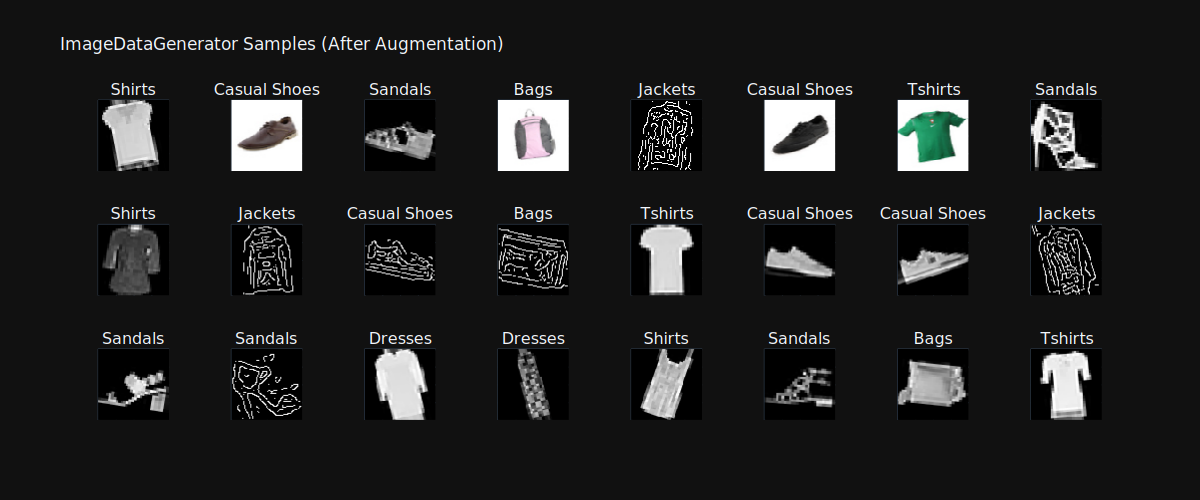

In [178]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print(f'Mode: {train_data.class_mode}')
print(f'Label (reference): {train_data.class_indices}')
num_class = len(train_data.class_indices)

def index_to_label(index, return_index = False):
    '''Translate class index to its real label'''
    # Binary: 0, 1, 2, ...
    # Categorical: (1 0 0), (0 1 0), (0 0 1), ...
    # Sparse (reference class): 0.0, 1.0, 2.0, ...
    # Sparse (prediction result): 0.1, 0.7, 0.2, ... (probability with sum = 1)
    if train_data.class_mode == 'categorical' or train_data.class_mode == 'sparse':
        if isinstance(index, np.ndarray): index = index.argmax()
    
    label = list(train_data.class_indices)[int(index)]
    if return_index: return label, int(index)
    return label

# View the first N batch only
n_batch = 3
# View N images per batch
n_sample = 8

fig = make_subplots(
    rows = n_batch, cols = n_sample,
    subplot_titles = [f'{i}' for i in range(n_batch * n_sample)],
)

print('Label (samples): ', end = '')
for i in range(n_batch):
    # if i == 0: print(train_data.shape)
    view_batch = train_data[i]

    for j in range(n_sample):
        # batch[0] = list of image array
        image = view_batch[0][j]
        
        # batch[1] = list of label array
        label_index = view_batch[1][j]
        print(label_index, end = ', ')

        # Update temporary title
        label = index_to_label(label_index)
        fig['layout']['annotations'][i * n_sample + j]['text'] = label

        if rescale: image *= 255
        fig.add_trace(go.Image(z = image, name = f'{label}'), row = i + 1, col = j + 1)

fig.update_layout(title = f'ImageDataGenerator Samples (After Augmentation)')
fig.update_xaxes(showticklabels = False).update_yaxes(showticklabels = False)
fig.show(width = 1200) # renderer = 'vscode'

In [62]:
# In case the generator doesn't get reset automatically
train_data.reset()
val_data.reset()

## Model Training

Compute class weight first to balance the weight of minority classes.

In [63]:
from sklearn.utils import class_weight

# https://stackoverflow.com/questions/42586475/
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes = np.unique(train_data.classes), 
    y = train_data.classes
)

class_weights = dict(zip(np.unique(train_data.classes), class_weights))
print(class_weights)

{0: 0.9975912872574663, 1: 0.9890412564463197, 2: 1.0518705495567087, 3: 1.0644088106838214, 4: 1.0114467218027088, 5: 0.9751545617380251, 6: 1.055719759168035, 7: 1.055719759168035, 8: 0.8419450992130305}


In [64]:
# Continue using saved model instead of starting again
# You can also skip these cells if training has been done before
continue_train = True

In [66]:
# Prevent memory leak on repeated execution
keras.backend.clear_session()

if continue_train:
    # Load existing model (along with its weight)
    model = keras.models.load_model(f'{misc_dir}/model.tf')
    print('Loaded existing model!')
else:
    # https://keras.io/api/applications/
    # https://keras.io/guides/transfer_learning/
    base_model = keras.applications.EfficientNetV2B3(
        input_shape = (target_height, target_width, 3),
        include_preprocessing = False if rescale else True,
        # Include the final flatten/dense layer
        include_top = False,
        pooling = None
    )

    model = keras.models.Sequential([
        base_model,

        # Don't use the included global pooling layer from base model
        # The base model layers are sometimes buggy and can't be used directly
        # We need the global pooling layer output for recommender system later
        keras.layers.GlobalMaxPooling2D(name = 'glob_max_pool_1'),

        keras.layers.Dense(units = 256, name = 'dense_1'),
        keras.layers.PReLU(name = 'prelu_1'),
        keras.layers.Dropout(rate = 0.3, name = 'dropout_1'),
        
        keras.layers.Dense(units = num_class, activation = 'softmax', name = 'dense_2')
    ])

model.summary() # expand_nested = True

Loaded existing model!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 3, 3, 1536)        12930622  
 nal)                                                            
                                                                 
 glob_max_pool_1 (GlobalMax  (None, 1536)              0         
 Pooling2D)                                                      
                                                                 
 dense_1 (Dense)             (None, 256)               393472    
                                                                 
 prelu_1 (PReLU)             (None, 256)               256       
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (Non

In [29]:
import pickle

logger = keras.callbacks.CSVLogger(
    filename = f'{misc_dir}/training.csv',
    append = False
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = f'{misc_dir}/model.tf',
    monitor = 'val_acc',
    save_best_only = True,
    save_weights_only = False,
    verbose = 1
)

if continue_train:
    # Restore last checkpoint threshold
    with open(f'{misc_dir}/checkpoint.pkl', 'rb') as f: 
        checkpoint.best = pickle.load(f)
        print('Loaded last checkpoint!')

early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 10,
    # No need if using checkpoint
    restore_best_weights = False,
    verbose = 1
)

class CheckMetrics(keras.callbacks.Callback):
    def __init__(self, metrics: str, threshold: float, mode: str):
        super().__init__()
        self.metrics = metrics
        self.val_metrics = 'val_' + metrics
        self.threshold = threshold
        self.mode = mode

    def on_epoch_end(self, epoch, logs: dict = None):
        met = logs.get(self.metrics)
        val_met = logs.get(self.val_metrics)

        if self.mode == 'max':
            condition = met >= self.threshold and val_met >= self.threshold
        else: # min
            condition = met <= self.threshold and val_met <= self.threshold

        if condition:
            print(f'Epoch {epoch + 1}: Reached {met} {self.metrics} and {val_met} {self.val_metrics}, stopping training')
            self.model.stop_training = True

check_metrics = CheckMetrics('acc', 0.95, 'max')

In [30]:
model.compile(
    optimizer = keras.optimizers.Adamax(learning_rate = 0.001),
    # Make sure "from_logits = False" if using activation like softmax
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = [ keras.metrics.SparseCategoricalAccuracy(name = 'acc') ]
)

training = model.fit(
    train_data,
    epochs = 200,
    validation_data = val_data,
    # steps_per_epoch = 128,
    # validation_steps = 128,
    class_weight = class_weights,
    callbacks = [logger, checkpoint, check_metrics, early_stop]
)

Epoch 1/200


2024-01-31 15:12:05.695882: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetv2-b3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1706713933.171865     145 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2110/2110 [==============================] - ETA: 0s - loss: 0.4684 - acc: 0.8342
Epoch 1: val_acc improved from -inf to 0.87082, saving model to /kaggle/working/misc/model.tf
2110/2110 [==============================] - 809s 353ms/step - loss: 0.4684 - acc: 0.8342 - val_loss: 0.4032 - val_acc: 0.8708
Epoch 2/200
2110/2110 [==============================] - ETA: 0s - loss: 0.2897 - acc: 0.8962
Epoch 2: val_acc improved from 0.87082 to 0.88060, saving model to /kaggle/working/misc/model.tf
2110/2110 [==============================] - 382s 181ms/step - loss: 0.2897 - acc: 0.8962 - val_loss: 0.3618 - val_acc: 0.8806
Epoch 3/200
2110/2110 [==============================] - ETA: 0s - loss: 0.2426 - acc: 0.9121
Epoch 3: val_acc improved from 0.88060 to 0.91118, saving model to /kaggle/working/misc/model.tf
2110/2110 [==============================] - 407s 193ms/step - loss: 0.2426 - acc: 0.9121 - val_loss: 0.2678 - val_acc: 0.9112
Epoch 4/200
2110/2110 [==============================] - ETA:

Save/load the trained model.

In [179]:
# Skip train will load some needed files
skip_train = False

In [351]:
if not skip_train:
    if not os.path.exists(f'{misc_dir}/model.tf'):
        model.save(f'{misc_dir}/model.tf')

    with open(f'{misc_dir}/checkpoint.pkl', 'wb') as f:
        pickle.dump(checkpoint.best, f)

    # Convert to TFLite (may slightly reduce accuracy)
    converter = tf.lite.TFLiteConverter.from_saved_model(f'{misc_dir}/model.tf')
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    with open(f'{misc_dir}/model.tflite', 'wb') as f:
        f.write(tflite_model)
        print('Saved model to TFLite!')

    # Easy backup when training on Kaggle
    shutil.make_archive('misc', 'zip', misc_dir)

if skip_train:
    model = keras.models.load_model(f'{misc_dir}/model.tf')

history = pd.read_csv(f'{misc_dir}/training.csv')

Saved model to TFLite!


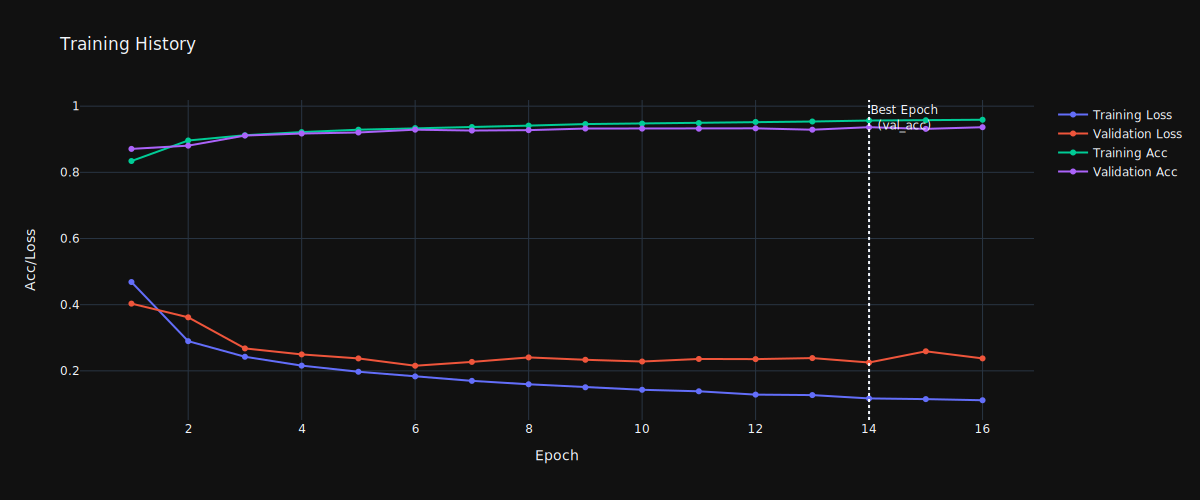

In [181]:
import plotly.graph_objects as go

fig = go.Figure()

metrics = 'val_acc'
mode = np.argmax

fig.add_trace(
    go.Scatter(
        x = [ i + 1 for i in range(len(history['loss'])) ],
        y = history['loss'],
        name = 'Training Loss'
    )
)

fig.add_trace(
    go.Scatter(
        x = [ i + 1 for i in range(len(history['val_loss'])) ],
        y = history['val_loss'],
        name = 'Validation Loss'
    )
)

fig.add_trace(
    go.Scatter(
        x = [ i + 1 for i in range(len(history['acc'])) ],
        y = history['acc'],
        name = 'Training Acc'
    )
)

fig.add_trace(
    go.Scatter(
        x = [ i + 1 for i in range(len(history['val_acc'])) ],
        y = history['val_acc'],
        name = 'Validation Acc'
    )
)

fig.add_vline(
    x = mode(history[metrics]) + 1,
    line_dash = 'dot',
    annotation_text = f'Best Epoch<br>({metrics})'
)

fig.update_layout(
    # https://plotly.com/python/reference/layout/
    title = { 'text': f'Training History' },
    # https://plotly.com/python/reference/layout/xaxis/
    xaxis = { 'title': 'Epoch' },
    # https://plotly.com/python/reference/layout/yaxis/
    yaxis = { 'title': 'Acc/Loss' },
    hovermode = 'x unified',
    hoverlabel = { 'namelength': -1 }
)

fig.show(width = 1200)

## Model Testing

In [182]:
# Images to test (use RGB when possible)
# Will be used again for recommender system
test_files = [
    f'{data1_dir}/images/32494.jpg',
    f'{data1_dir}/images/15322.jpg',
    f'{data1_dir}/images/12967.jpg',
    f'{data1_dir}/images/11175.jpg',
    f'{data1_dir}/images/14659.jpg'
]

temp = df[df[x_col].isin(test_files)]
test_files = temp[x_col].values.tolist()
test_labels = temp[y_col].values.tolist()

print(test_files)
print(test_labels)

['input/fashion-product-images-small/images/12967.jpg', 'input/fashion-product-images-small/images/11175.jpg', 'input/fashion-product-images-small/images/14659.jpg', 'input/fashion-product-images-small/images/15322.jpg', 'input/fashion-product-images-small/images/32494.jpg']
['Sandals', 'Sweaters', 'Trousers', 'Jackets', 'Casual Shoes']


In [183]:
from keras.utils import load_img, img_to_array

def image_loader(file_paths: list, target_height = 80, target_width = 80, rescale = False):
    for i, file in enumerate(file_paths):
        image = load_img(
            file,
            color_mode = 'rgb',
            target_size = (target_height, target_width),
            interpolation = 'bicubic'
        )
        image = img_to_array(image)
        if rescale: image /= 255

        # Expand dimensions if there is only 1 image
        image = np.expand_dims(image, axis = 0)
        # Stack images if there are more than 1
        if i == 0: images = image
        else: images = np.vstack((images, image))
    
    return images

images = image_loader(test_files, rescale = rescale)
label_index = model.predict(images)

# Print model predictions for each image (row)
# Each column is representing class probability
with np.printoptions(precision = 5, suppress = True):
    print(label_index)

1/1 [==============================] - 3s 3s/step
[[0.      0.      0.      0.      1.      0.      0.      0.      0.     ]
 [0.00019 0.      0.      0.00003 0.      0.00016 0.24503 0.      0.75459]
 [0.      0.      0.      0.      0.      0.      0.      1.      0.     ]
 [0.00003 0.      0.00015 0.99299 0.      0.00121 0.00552 0.00001 0.00009]
 [0.      0.99998 0.      0.      0.00002 0.      0.      0.      0.     ]]


input/fashion-product-images-small/images/12967.jpg (Sandals) -> Sandals (confidence: 99.99998%)
input/fashion-product-images-small/images/11175.jpg (Sweaters) -> Tshirts (confidence: 75.45916%)
input/fashion-product-images-small/images/14659.jpg (Trousers) -> Trousers (confidence: 100.0%)
input/fashion-product-images-small/images/15322.jpg (Jackets) -> Jackets (confidence: 99.29922%)
input/fashion-product-images-small/images/32494.jpg (Casual Shoes) -> Casual Shoes (confidence: 99.99788%)


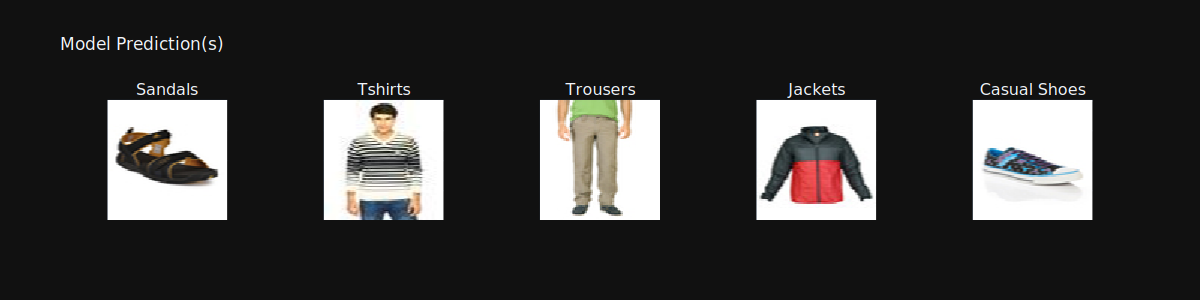

In [184]:
predictions = []

for i, index in enumerate(label_index):
    label, confidence = index_to_label(index, return_index = True)
    confidence = np.round(index[confidence] * 100, 5)
    predictions.append((label, confidence))
    print(f'{test_files[i]} ({test_labels[i]}) -> {label} (confidence: {confidence}%)')

fig = make_subplots(
    rows = 1,
    cols = len(predictions),
    subplot_titles = [ i[0] for i in predictions ]
)

for i, image in enumerate(images.copy()):
    if rescale: image *= 255
    fig.add_trace(go.Image(z = image), row = 1, col = i + 1)

fig.update_layout(title_text = f'Model Prediction(s)')
fig.update_xaxes(showticklabels = False).update_yaxes(showticklabels = False)
fig.show(height = 300, width = 1200)

The model still can mistake sweaters as t-shirts, but that's kind of expected.

## Recommender System
Recommends similar products based on sample image(s).

In [185]:
# Get the index of global pooling/embedding layer
layer_name = [ layer.name for layer in model.layers ]
print(layer_name)

['efficientnetv2-b3', 'glob_max_pool_1', 'dense_1', 'prelu_1', 'dropout_1', 'dense_2']


In [215]:
recsys_model = keras.models.Model(
    inputs = model.inputs,
    # Global pooling layer at the end of base model
    outputs = model.layers[1].output
)

print(model.layers[1].output.shape)

(None, 1536)


Since recommender system should also consider colors, embedding should only be applied on the first dataset (that contains RGB images).

In [306]:
rec_gen = ImageDataGenerator(
    rescale = scale_factor,
    preprocessing_function = val_preproc
)

rec_data = rec_gen.flow_from_dataframe(
    dataframe = df1,
    x_col = x_col,
    y_col = y_col,
    validate_filenames = False,
    target_size = (target_height, target_width),
    # This one is important
    shuffle = False
)

temp = pd.DataFrame(recsys_model.predict(rec_data))

Found 44441 non-validated image filenames belonging to 142 classes.
1389/1389 [==============================] - 200s 143ms/step


In [307]:
df_emb = pd.concat(
    [ df1[['id', x_col, y_col]].reset_index(drop = True), temp ],
    axis = 1
)

print(len(df_emb))
df_emb.head()

44441


,id,image,articleType,0,1,2,3,4,5,6,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,15970,input/fashion-product-images-small/images/1597...,Shirts,-0.000822,-0.000301,0.676868,-0.000278,-0.000029,0.083035,0.016659,...,-0.002077,0.959557,-0.000052,-0.000900,-0.000888,-0.000603,-0.000102,-0.000740,-0.002221,-0.000012
1,39386,input/fashion-product-images-small/images/3938...,Jeans,4.179479,-0.000393,0.411552,-0.000980,0.688246,2.653780,1.332641,...,1.902685,-0.000376,0.648495,1.148537,0.566533,0.078138,0.607965,-0.000661,-0.001095,2.146308
2,59263,input/fashion-product-images-small/images/5926...,Watches,0.261040,-0.002322,-0.003599,-0.003019,-0.003014,-0.034249,0.746913,...,-0.006975,-0.002265,0.005484,-0.003844,-0.000526,-0.000993,-0.006069,-0.000141,-0.010048,-0.000741
3,21379,input/fashion-product-images-small/images/2137...,Track Pants,1.509664,-0.000107,0.292668,-0.000984,0.281316,1.370714,1.434359,...,0.951065,-0.000016,0.730172,0.427091,0.153636,0.059614,0.331851,-0.000275,-0.000231,1.240809
4,53759,input/fashion-product-images-small/images/5375...,Tshirts,0.754925,-0.060036,0.042004,-0.074476,-0.019834,-0.128417,-0.046946,...,-0.080353,-0.005160,-0.095834,-0.037116,-0.004095,-0.024765,-0.045484,-0.107839,-0.083232,-0.012128


Similarity can be calculated using different metrics (cosine, eclidean, minkowski, manhattan, etc). See the docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html).

In [352]:
from sklearn.neighbors import NearestNeighbors

# Embedding columns (0 - 1535)
emb_cols = [i for i in df_emb.columns if i not in ['id', x_col, y_col]]

def get_recommendations(file_paths: list, rec_len: int, same_class_only = True, metric = 'euclidean'):
    # Key = input file (image path)
    # Values = recommended files (image path list)
    recommendations = {}

    for file in file_paths:
        # Get row of current input file
        df_cur = df_emb[ df_emb[x_col] == file ]
        # Filter rows that have same class as input file
        if same_class_only:
            df_compare = df_emb[ df_emb[y_col] == df_cur[y_col].values[0] ]
        else:
            df_compare = df_emb

        # +1 since the closest neighbor will be the input image itself
        nn = NearestNeighbors(n_neighbors = rec_len + 1, metric = metric)
        nn.fit(df_compare[emb_cols])

        # Will return iloc of N nearest neighbors
        result = nn.kneighbors(df_cur[emb_cols], return_distance = False)[0]
        rec_list = []

        # Get X recommendations for each input file
        # Index 0 will be the input image itself (skipped)
        for i, rec_iloc in enumerate(result):
            if i == 0: continue
            rec_file = df_compare.iloc[rec_iloc][x_col]
            rec_list.append(rec_file)
        
        recommendations[file] = rec_list
    
    return recommendations

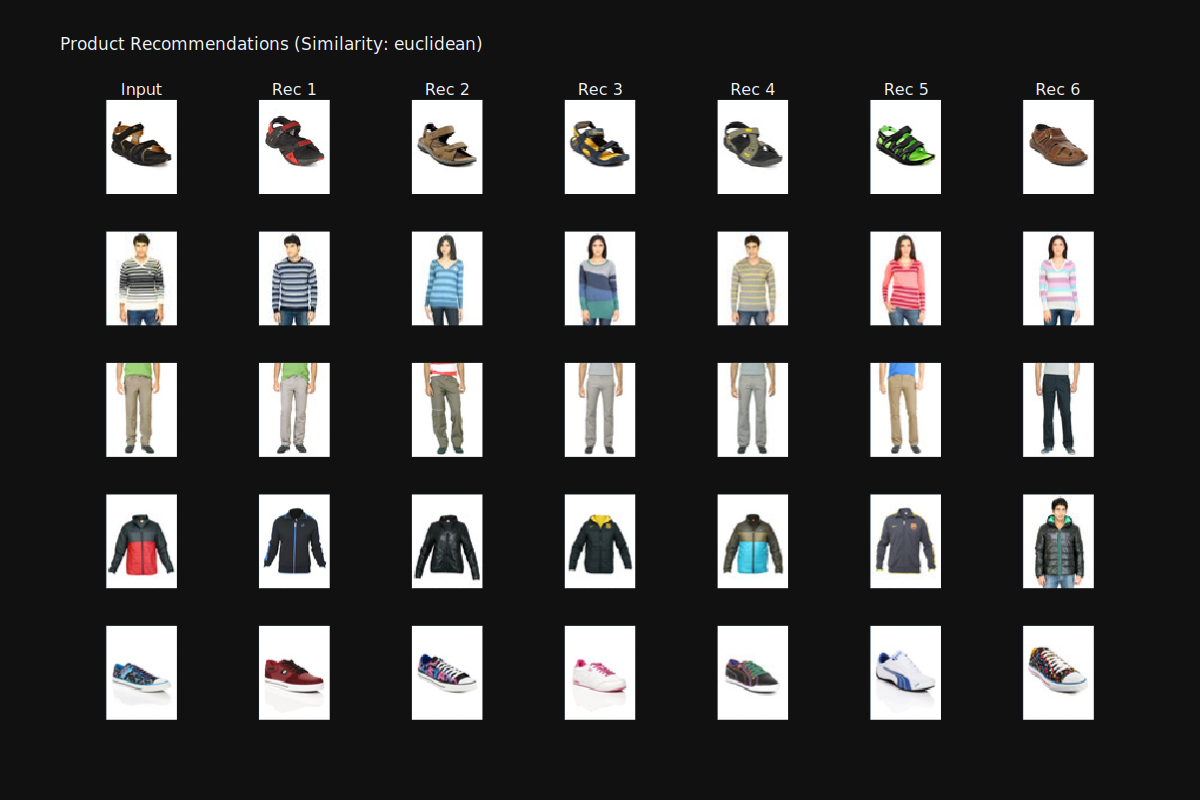

In [353]:
# Distance similarity metric
metric = 'euclidean'
# How many recommendations for each input?
rec_len = 6

rec = get_recommendations(test_files, rec_len = rec_len, metric = metric)

fig = make_subplots(
    rows = len(test_files),
    # +1 to show the input image itself
    cols = rec_len + 1,
    column_titles = [
        'Input' if i == 0 else f'Rec {i}' for i in range(rec_len + 1)
    ]
)

for i, key in enumerate(rec.keys()):
    image = Image.open(key).convert('RGB')
    fig.add_trace(go.Image(z = image), row = i + 1, col = 1)

    for j, val in enumerate(rec[key]):
        image = Image.open(val).convert('RGB')
        fig.add_trace(go.Image(z = image), row = i + 1, col = j + 2)

fig.update_layout(title = f'Product Recommendations (Similarity: {metric})')
fig.update_xaxes(showticklabels = False).update_yaxes(showticklabels = False)
fig.show(height = 800, width = 1200)

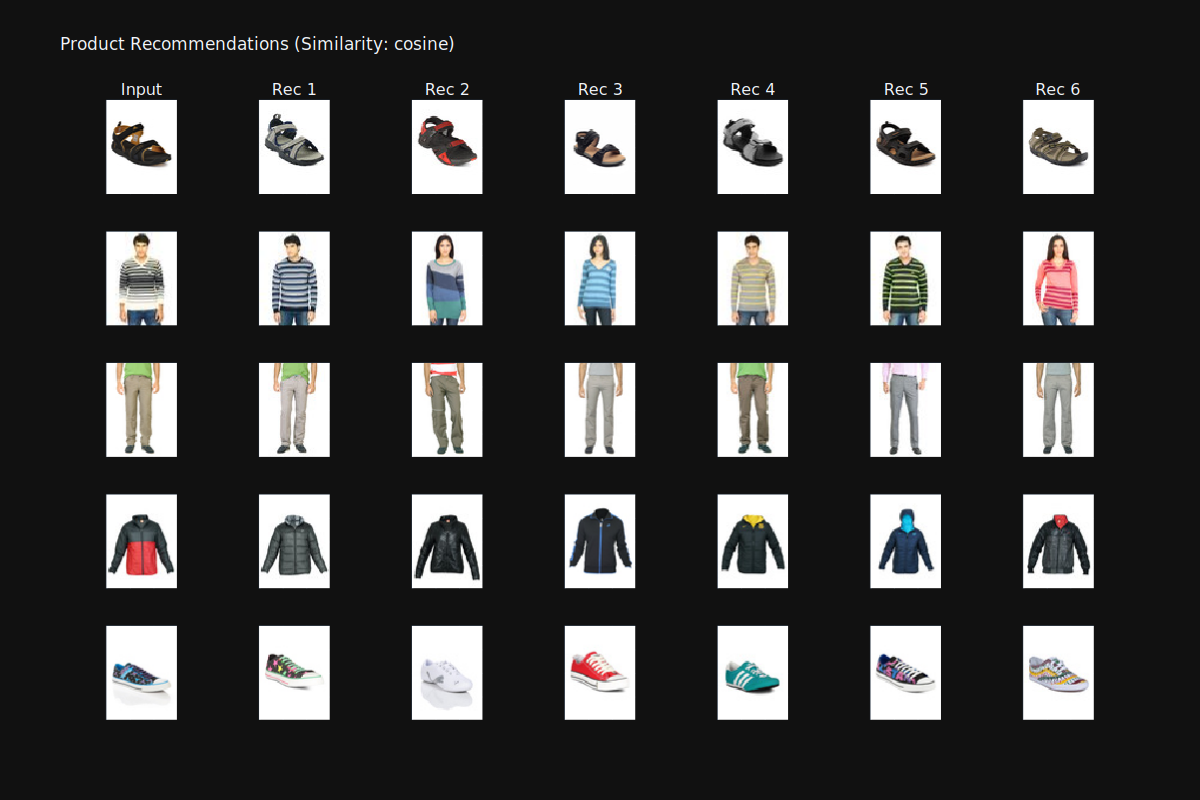

In [354]:
# Distance similarity metric
metric = 'cosine'
# How many recommendations for each input?
rec_len = 6

rec = get_recommendations(test_files, rec_len = rec_len, metric = metric)

fig = make_subplots(
    rows = len(test_files),
    # +1 to show the input image itself
    cols = rec_len + 1,
    column_titles = [
        'Input' if i == 0 else f'Rec {i}' for i in range(rec_len + 1)
    ]
)

for i, key in enumerate(rec.keys()):
    image = Image.open(key).convert('RGB')
    fig.add_trace(go.Image(z = image), row = i + 1, col = 1)

    for j, val in enumerate(rec[key]):
        image = Image.open(val).convert('RGB')
        fig.add_trace(go.Image(z = image), row = i + 1, col = j + 2)

fig.update_layout(title = f'Product Recommendations (Similarity: {metric})')
fig.update_xaxes(showticklabels = False).update_yaxes(showticklabels = False)
fig.show(height = 800, width = 1200)

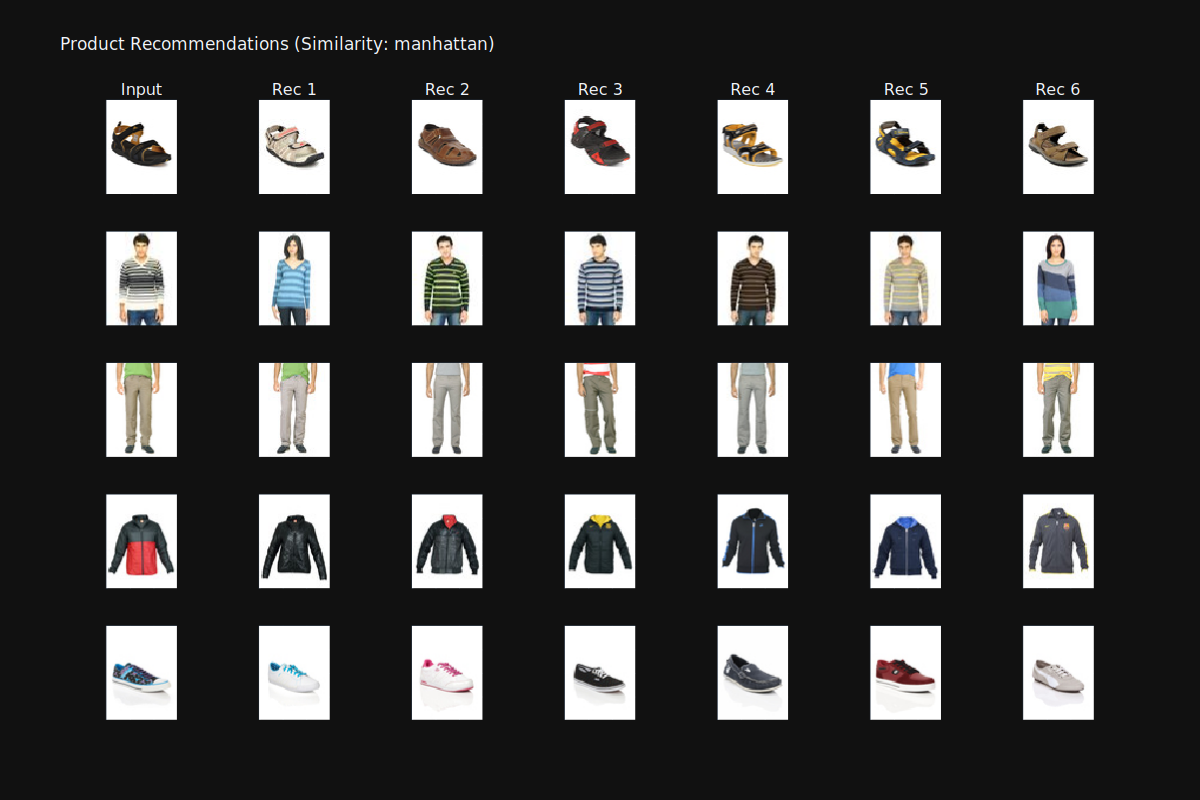

In [355]:
# Distance similarity metric
metric = 'manhattan'
# How many recommendations for each input?
rec_len = 6

rec = get_recommendations(test_files, rec_len = rec_len, metric = metric)

fig = make_subplots(
    rows = len(test_files),
    # +1 to show the input image itself
    cols = rec_len + 1,
    column_titles = [
        'Input' if i == 0 else f'Rec {i}' for i in range(rec_len + 1)
    ]
)

for i, key in enumerate(rec.keys()):
    image = Image.open(key).convert('RGB')
    fig.add_trace(go.Image(z = image), row = i + 1, col = 1)

    for j, val in enumerate(rec[key]):
        image = Image.open(val).convert('RGB')
        fig.add_trace(go.Image(z = image), row = i + 1, col = j + 2)

fig.update_layout(title = f'Product Recommendations (Similarity: {metric})')
fig.update_xaxes(showticklabels = False).update_yaxes(showticklabels = False)
fig.show(height = 800, width = 1200)

Weak observation (no base theory):
- Euclidean seems to be more tolerant of different colors or shapes, but still produce good results (although kinda bad at recommending shoes)
- Cosine seems to prioritize products that have similar shapes, but may fail at recommending products that have a many color variations (especially opposite colors)
- Manhattan is a slightly worse version of euclidean (at recommending shoes)

## Misc

Changelog:
- v1: Using Resnet50 v2, global max pooling, adam (0.005 learning rate). Acc and val_acc stagnated around 72%
- v2: Change to EfficientNetB3 v2, global avg pooling, adamax (0.001 learning rate). Combined data with vehicle color dataset and added median filter + gaussian blur preprocessing. Acc 88%, val_acc 75%
- v3: Continuing v2, changed generator seed from 1337 to 1234. Steps per epoch 320, validation steps 80. Accuracy still doesn't increase
- v4: Continuing v3, using mini-batch (32 samples per epoch), 2000 epoch. Accuracy still doesn't increase
- v5: Continuing v4, increased gaussian intensity (1.0 to 2.0) but lower the chance (0.5 to 0.3). Removed median filter since it doesn't do much. Accuracy still doesn't increase
- v6: Train again from scratch but with global max pooling and default batch size. Added 1 more dataset (Digikala fashion color) and simplified class category (maroon -> red, navy blue -> blue, etc), val_acc still stuck around 75%
- v7 (rework): Changed from `baseColour` to `articleType` classification. Changed gaussian blur with canny filter. Added fashion MNIST dataset. Achieved 92% accuracy (early stop, can be higher). Can't be used as recommender system since global pooling layer from base model (EfficientNetB3 v2) can't be extracted
- **v8 (currently used):** Same as v7, but separated global pooling layer from base model. Added recommender system

Todo:
- ~~Prediction and [recommender system](https://www.kaggle.com/code/marlesson/building-a-recommendation-system-using-cnn)~~
- Visualize layers with `visualkeras` or `tf-explain`
- ~~Explore `skimage` or `imgaug`, and their filter options ([HOG](https://www.kaggle.com/code/anirbanmalick/image-classification-using-hog-knn-98-acc), canny, sobel, etc)~~
- Experiment with encoder & decoder ([reference](https://www.kaggle.com/code/ohseokkim/base-denoising-autoencoder-dimension-reduction))
- Make a HTML test page for model prediction and recommender system (TensorFlow.js)
- Recolorization ([reference](https://www.kaggle.com/code/basu369victor/image-colorization-basic-implementation-with-cnn))
- Clothes segmentation (keyword) ([dataset 1](https://www.kaggle.com/datasets/balraj98/clothing-coparsing-dataset), [dataset 2](https://www.kaggle.com/datasets/marquis03/high-resolution-viton-zalando-dataset)), can be used to produce better product color classification?